In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import histlite as hl

import pickle

import uproot

import scipy.interpolate as interp

from configparser import ConfigParser

import scipy.optimize as opt

import matplotlib as mpl
import matplotlib.pylab as plt

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

def GetBinCenters( histlite_hist ):
    return (histlite_hist.bins[0][1:] + histlite_hist.bins[0][:-1])/2.

# Parse the config file

In [2]:
cfg_file = '/g/g20/lenardo1/software/sis3316_replay/config_tim_daniels.ini'

config = ConfigParser()
config.read(cfg_file)

sections = config.sections()

channel_names = [section for section in sections if 'ch' in section]

desired_variables = ['ngcut','ngain_m','ngain_b','th_deg']

config_params = {}

for ch in channel_names:
    
    param_dict = {}
    
    for var in desired_variables:
        param_dict[var] = float(config.get(ch,var))
        
    config_params[ch] = param_dict
    
    
print(config_params)
        

def pulse_height_cut_val( ngain_m, ngain_b ):
     
    
    return 0.239 * ngain_m + ngain_b




{'ch0': {'ngcut': 8.594, 'ngain_m': 3760.8, 'ngain_b': 0.7, 'th_deg': 0.0}, 'ch1': {'ngcut': 9.0, 'ngain_m': 3856.7, 'ngain_b': -4.45, 'th_deg': 0.0}, 'ch2': {'ngcut': 9.5, 'ngain_m': 3822.3, 'ngain_b': -8.353, 'th_deg': 0.0}, 'ch3': {'ngcut': 7.5, 'ngain_m': 3792.65, 'ngain_b': 13.98, 'th_deg': 3.0}, 'ch4': {'ngcut': 10.75, 'ngain_m': 3790.05, 'ngain_b': 11.56, 'th_deg': 3.0}, 'ch5': {'ngcut': 11.0, 'ngain_m': 3807.5, 'ngain_b': 31.0, 'th_deg': 3.0}, 'ch6': {'ngcut': 9.0, 'ngain_m': 3819.6, 'ngain_b': 45.65, 'th_deg': 6.0}, 'ch7': {'ngcut': 8.5, 'ngain_m': 3740.1, 'ngain_b': 21.6, 'th_deg': 6.0}, 'ch8': {'ngcut': 7.25, 'ngain_m': 3955.0, 'ngain_b': 21.56, 'th_deg': 6.0}, 'ch9': {'ngcut': 8.016, 'ngain_m': 3811.1, 'ngain_b': 68.74, 'th_deg': 90.0}, 'ch10': {'ngcut': 8.0, 'ngain_m': 8113.41, 'ngain_b': -153.8, 'th_deg': 90.0}, 'ch16': {'ngcut': 9.25, 'ngain_m': 3855.54, 'ngain_b': -8.18, 'th_deg': 9.0}, 'ch17': {'ngcut': 10.5, 'ngain_m': 3766.13, 'ngain_b': 46.25, 'th_deg': 9.0}, 'ch18'

# Load the data

In [3]:
datadir = '/p/lustre1/lenardo1/tunl_cs136_data/replayed/'
thisds = 'slurm_run30180_NoCutOnLS/'

rootfiles = [filename for filename in os.listdir(datadir+thisds) \
                                     if filename.endswith('.root') ]

    
data_list = []

nfiles = len(rootfiles)

bad_counter = 0

for thisfile in rootfiles:

    fullpath = datadir + thisds + '/' + thisfile

    try:
        data_list.append( \
                uproot.open(fullpath)['ndet_events'].arrays( ["*"], \
                                            outputtype=pd.DataFrame ) )
    except KeyError as e:
        print('{} for {}'.format(e,thisfile))
        bad_counter += 1
        
print('{} of {} files did not have the ndet_events tree.'.format(
                    bad_counter, nfiles))

data = pd.concat(data_list,ignore_index=True)

not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_31.root for run30180_31.root
not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_110.root for run30180_110.root
not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_66.root for run30180_66.root
not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_135.root for run30180_135.root
not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_10.root for run30180_10.root
not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_83.root for run30180_83.root
not found: b'ndet_events'
 in file: /p/lustre1/lenardo1/tunl_cs136_data/replayed/slurm_run30180_NoCutOnLS//run30180_42.root fo

Text(0, 0.5, 'Pulse height (ADC)')

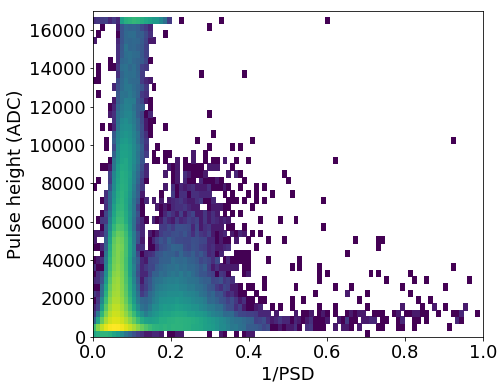

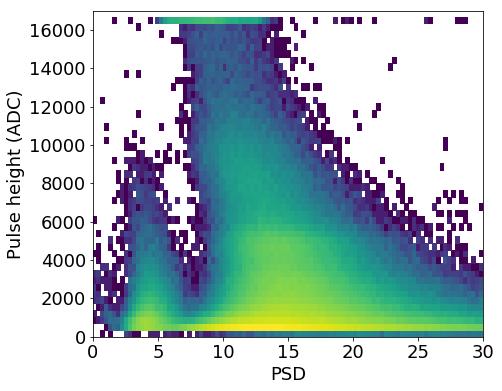

In [4]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

thisch = 0.



# psd_mask = (data['ndet_PSD']>2.2) & \
#             (data['ndet_PSD']<9.) & \
#             (data['ndet_PH'] < 12000.) & \
#             np.invert( (data['ndet_PH']>8000.)&(data['ndet_PSD']>6.) )

psd_mask = (data['ndet_ch']==thisch) 

# plt.plot( 1./np.abs(data['ndet_PSD'].loc[psd_mask]), data['ndet_PH'].loc[psd_mask], 
#          'o',color=(0.,0.,1.,0.14),markersize=1)
par = plt.hist2d(1./np.abs(data['ndet_PSD'].loc[psd_mask]), \
                 data['ndet_PH'].loc[psd_mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(0.,1.,100),np.linspace(0.,17000.) ) )



plt.xlim(0.,1.)

plt.xlabel('1/PSD')
plt.ylabel('Pulse height (ADC)')

plt.figure(2)

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

thisch = 0.



psd_mask = (data['ndet_PSD']>2.2) & \
            (data['ndet_PSD']<9.) & \
            (data['ndet_PH'] < 12000.) & \
            np.invert( (data['ndet_PH']>8000.)&(data['ndet_PSD']>6.) )

psd_mask = (data['ndet_ch']==thisch) 

# plt.plot( np.abs(data['ndet_PSD'].loc[psd_mask]), data['ndet_PH'].loc[psd_mask], 
#          'o',color=(0.,0.,1.,0.14),markersize=1)

par = plt.hist2d(np.abs(data['ndet_PSD'].loc[psd_mask]), \
                 data['ndet_PH'].loc[psd_mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(0.,30.,100),np.linspace(0.,17000.) ) )



plt.xlim(0.,30.)


plt.xlabel('PSD')
plt.ylabel('Pulse height (ADC)')






# PSD with cuts applied in the replay code





/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/matplotlib/colors.py:1031: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/matplotlib/colors.py:1032: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


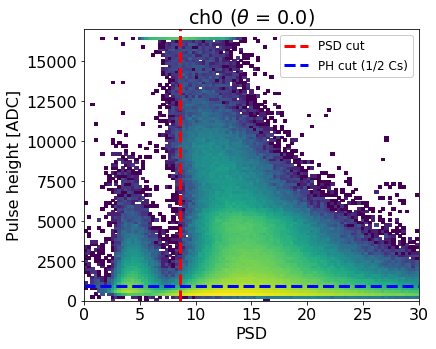

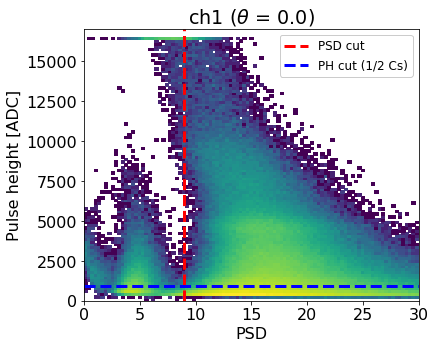

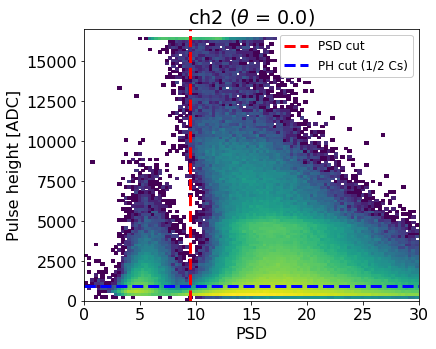

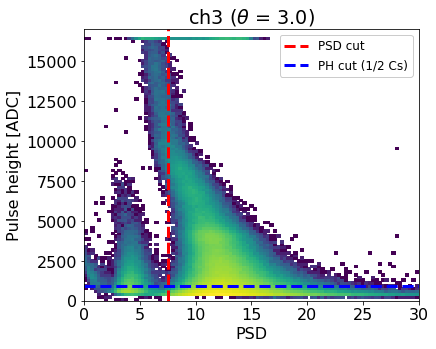

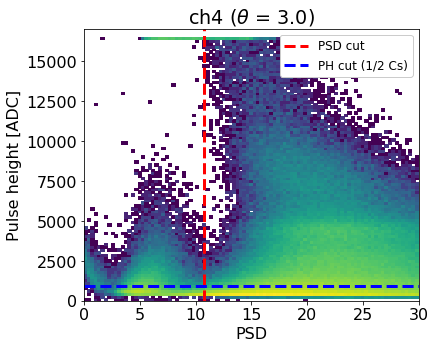

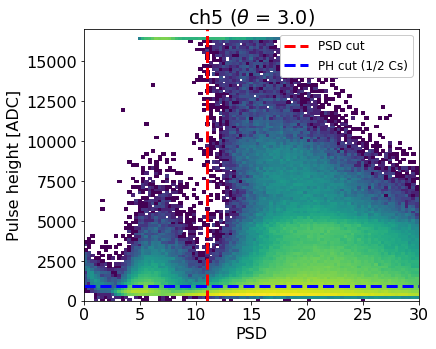

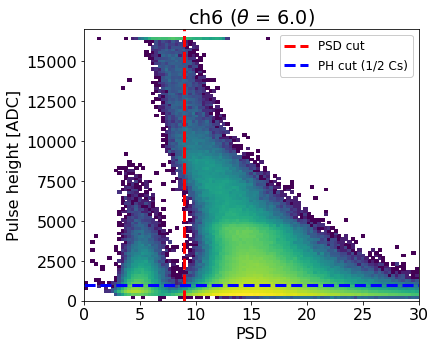

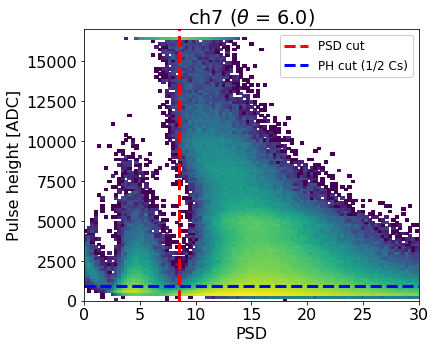

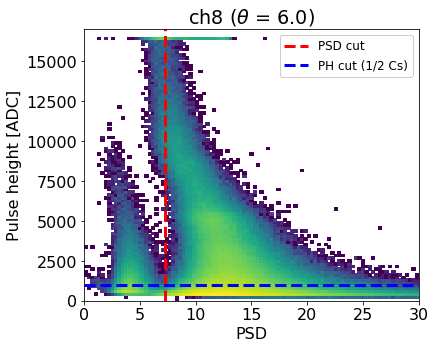

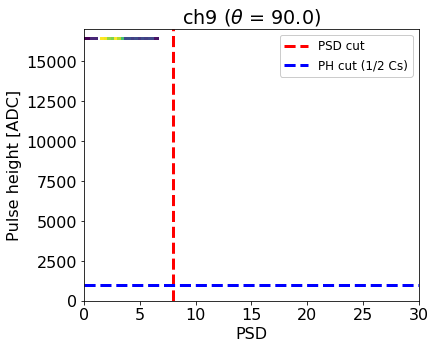

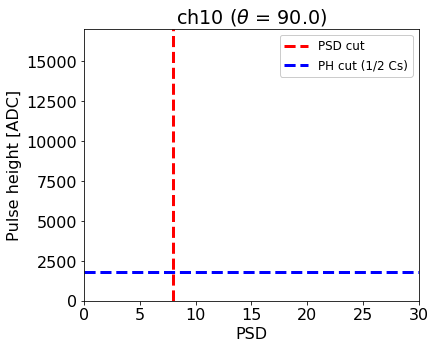

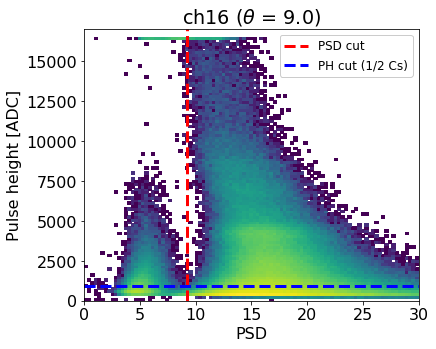

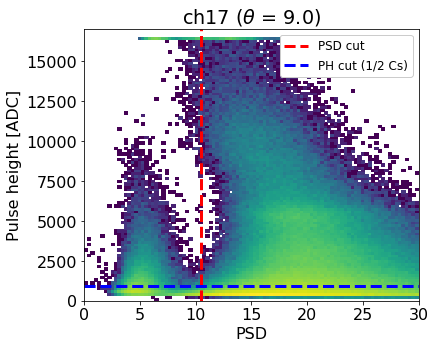

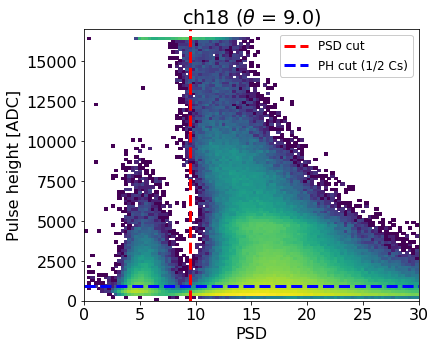

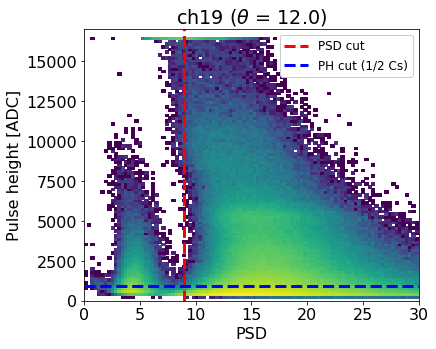

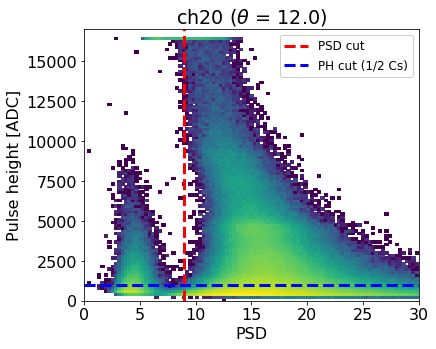

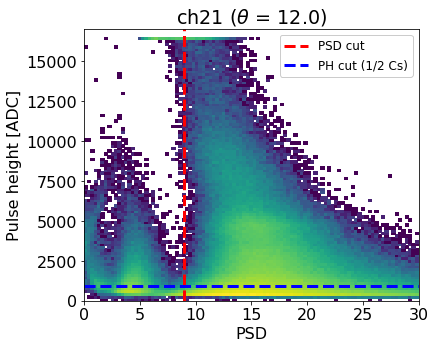

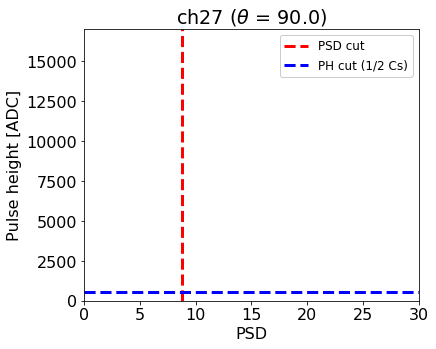

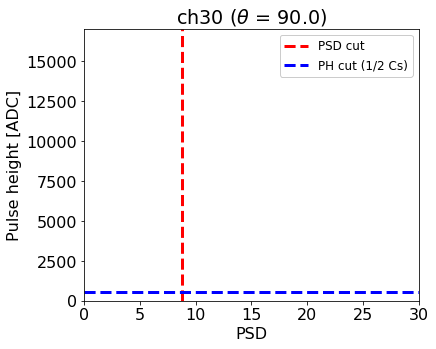

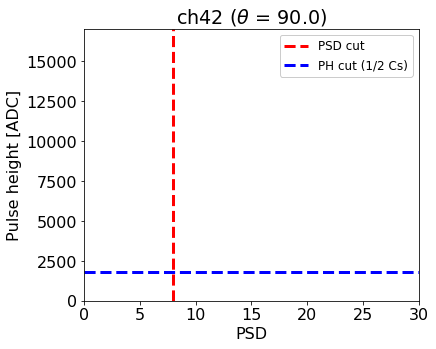

In [5]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (6,5)

for chname in channel_names:
    
    cfg = config_params[chname]
    
    chnum = float(chname[2:])
    
    mask = (data['ndet_ch']==chnum)
    
    xrange = [0.,30.]
    yrange = [0.,17000.]
    
    plt.figure(int(chnum))
    
    plt.title(r'{} ($\theta$ = {})'.format(chname,cfg['th_deg']))
    plt.xlabel('PSD')
    plt.ylabel('Pulse height [ADC]')
    
    #print(cfg)
    
    par = plt.hist2d(np.abs(data['ndet_PSD'].loc[mask]), \
                 data['ndet_PH'].loc[mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(xrange[0],xrange[1],100),\
                        np.linspace(yrange[0],yrange[1],100) ) )
    
    # Plot the PSD cut
    plt.plot( np.ones(10) * cfg['ngcut'],\
            np.linspace(yrange[0],yrange[1],10),'--r',\
            linewidth=3, label='PSD cut')
    
    ph_cut = pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )
    # Plot the 1/2Cs threshold
    plt.plot( np.linspace(xrange[0],xrange[1],10),\
            np.ones(10) * ph_cut, '--b', \
            linewidth=3, label='PH cut (1/2 Cs)')
    
    
    plt.legend(fontsize=12,framealpha=1.)
    

    plt.savefig('Plots/PSDAnalysis/{}_psd_vs_pulse_height.png'.format(chname),\
               dpi=200,bbox_inches='tight')
    
    
    #print(chnum)

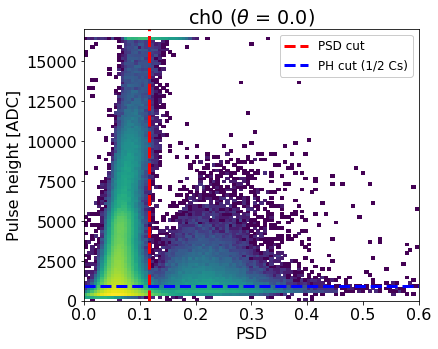

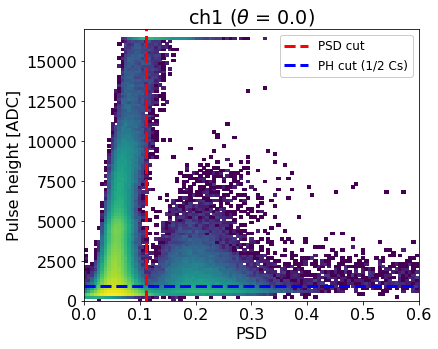

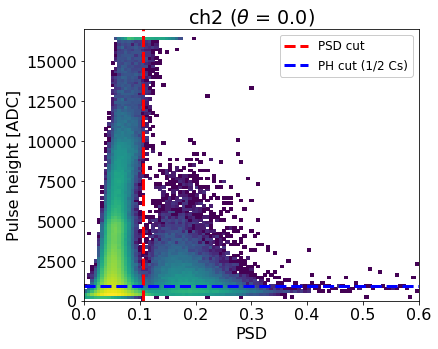

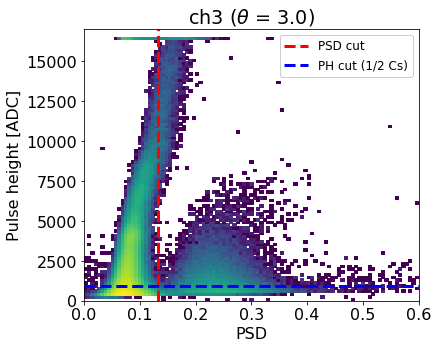

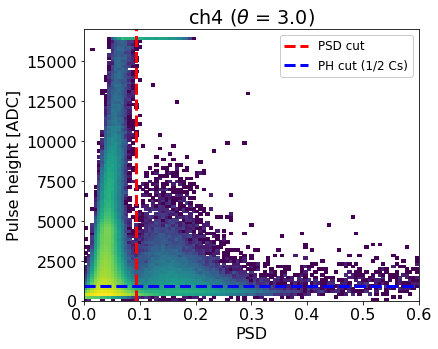

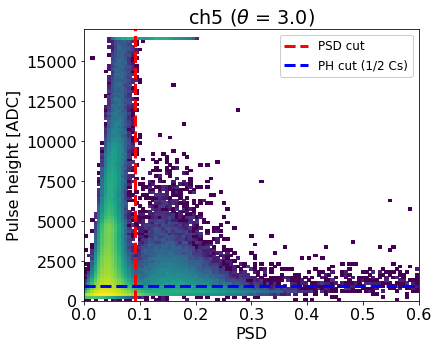

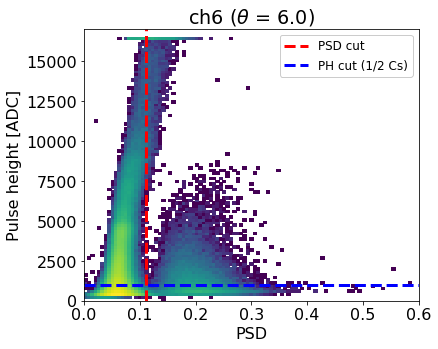

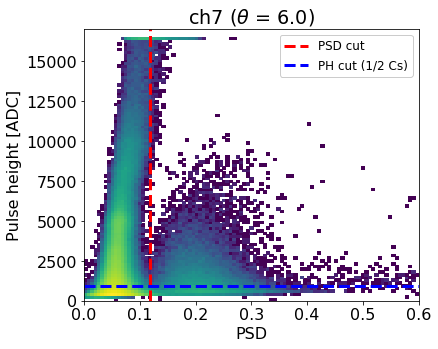

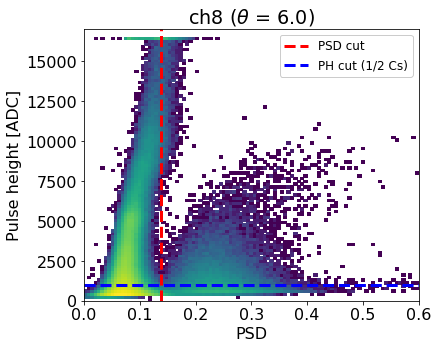

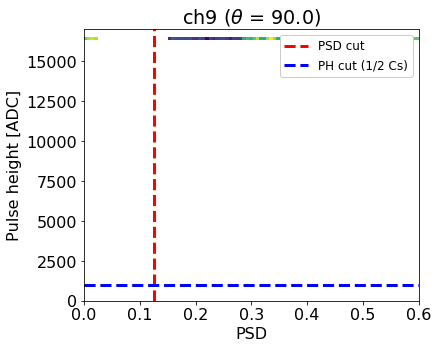

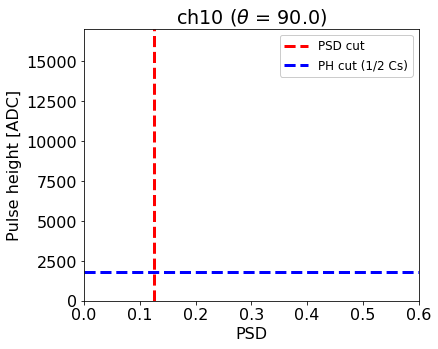

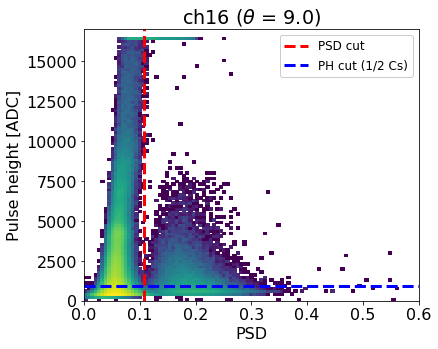

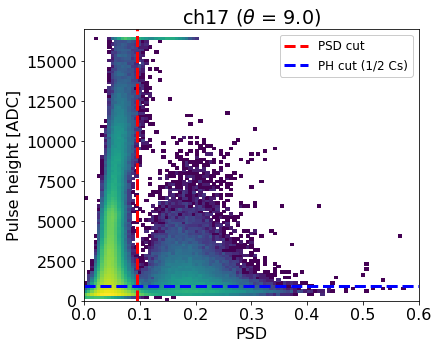

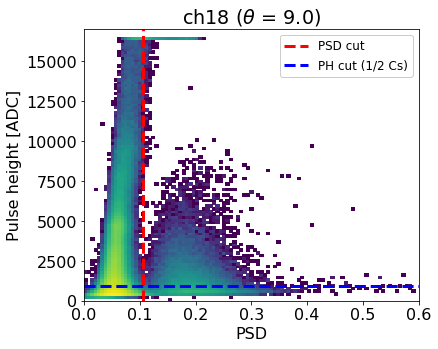

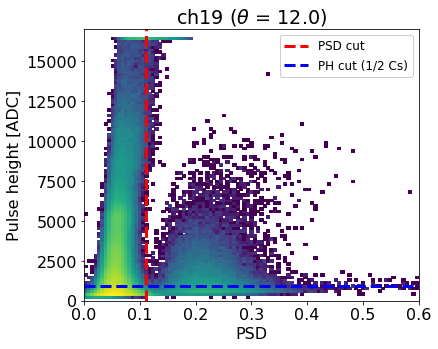

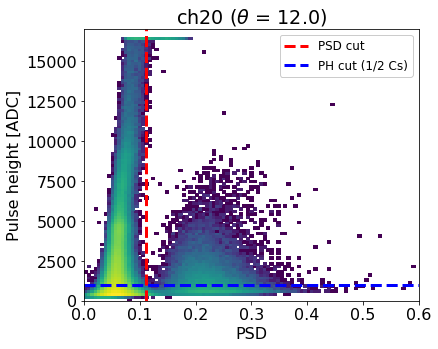

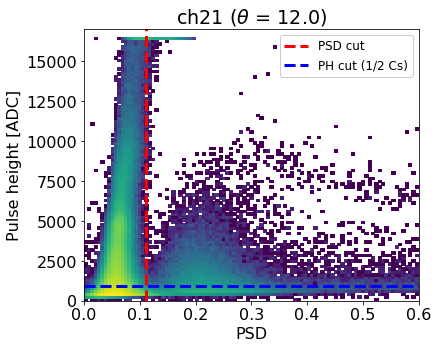

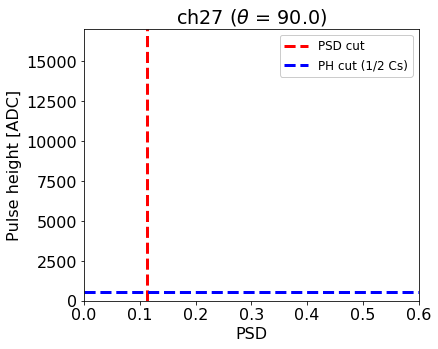

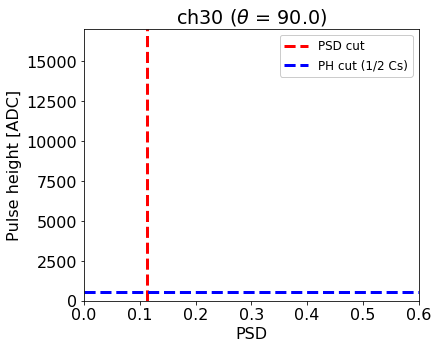

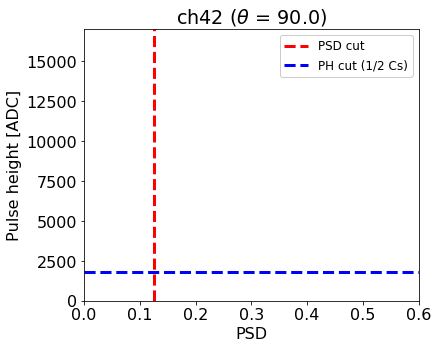

In [6]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (6,5)

for chname in channel_names:
    
    cfg = config_params[chname]
    
    chnum = float(chname[2:])
    
    mask = (data['ndet_ch']==chnum)
    
    xrange = [0.,0.6]
    yrange = [0.,17000.]
    
    plt.figure(int(chnum))
    
    plt.title(r'{} ($\theta$ = {})'.format(chname,cfg['th_deg']))
    plt.xlabel('PSD')
    plt.ylabel('Pulse height [ADC]')
    
    #print(cfg)
    
    par = plt.hist2d(1./np.abs(data['ndet_PSD'].loc[mask]), \
                 data['ndet_PH'].loc[mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(xrange[0],xrange[1],100),\
                        np.linspace(yrange[0],yrange[1],100) ) )
    
    # Plot the PSD cut
    plt.plot( 1./(np.ones(10) * cfg['ngcut']),\
            np.linspace(yrange[0],yrange[1],10),'--r',\
            linewidth=3, label='PSD cut')
    
    ph_cut = pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )
    # Plot the 1/2Cs threshold
    plt.plot( np.linspace(xrange[0],xrange[1],10),\
            np.ones(10) * ph_cut, '--b', \
            linewidth=3, label='PH cut (1/2 Cs)')
    
    
    plt.legend(fontsize=12,framealpha=1.)
    
    plt.savefig('Plots/PSDAnalysis/{}_inverse_psd_vs_pulse_height.png'.format(chname),\
               dpi=200,bbox_inches='tight')
    

# Time distribution of different populations






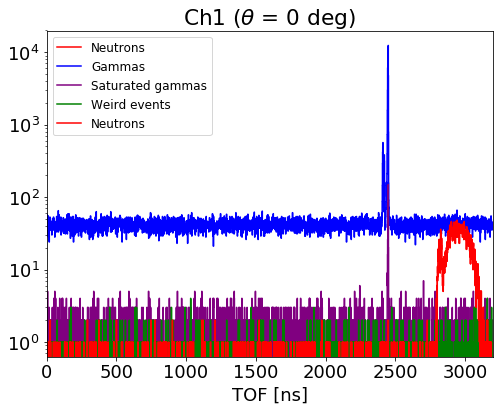

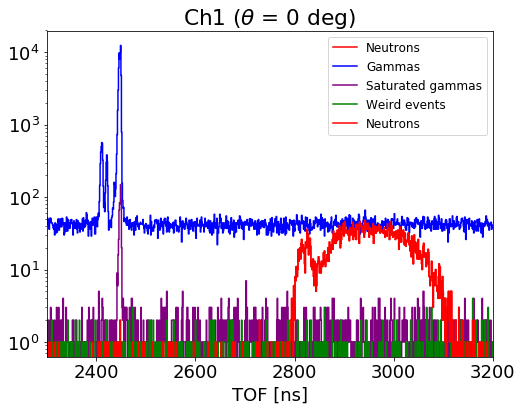

In [7]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

mask = (data['ndet_ch']==1.)

weird_evt_cut = mask & \
            (data['ndet_PSD']>0.) & \
            (data['ndet_PSD']< 2.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 15000.)

neutron_cut = mask & \
            (data['ndet_PSD']>2.) & \
            (data['ndet_PSD']< 7.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 10000.)

gamma_cut = mask & \
            (data['ndet_PSD']>7.) & \
            (data['ndet_PSD']< 25.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 10000.)

saturated_gamma_cut = mask & (data['ndet_PH'] > 16000.)


hweird = hl.hist(data['ndet_tof'].loc[weird_evt_cut],\
                bins=np.linspace(0.,3200.,3201))

hneutron = hl.hist(data['ndet_tof'].loc[neutron_cut],\
                bins=np.linspace(0.,3200.,3201))

hgamma = hl.hist(data['ndet_tof'].loc[gamma_cut],\
                bins=np.linspace(0.,3200.,3201))

hsatgamma = hl.hist(data['ndet_tof'].loc[saturated_gamma_cut],\
                bins=np.linspace(0.,3200.,3201))


hl.plot1d(hneutron, color='r', label='Neutrons')
hl.plot1d(hgamma, color='b', label='Gammas')
hl.plot1d(hsatgamma, color=(0.5,0.,0.5), label='Saturated gammas')
hl.plot1d(hweird, color='g', label='Weird events')
hl.plot1d(hneutron, color='r', label='Neutrons')

plt.xlabel('TOF [ns]')
plt.legend(fontsize=12)
#plt.ylim(0.,100.)

plt.xlim(2300.,3200.)
plt.xlim(0.,3200.)
plt.yscale('log')

plt.title(r'Ch1 ($\theta$ = 0 deg)')

plt.savefig('Plots/PSDAnalysis/psd_spectrum_ch1_full.png',\
           dpi=200,bbox_inches='tight')




plt.figure(2)

hl.plot1d(hneutron, color='r', label='Neutrons')
hl.plot1d(hgamma, color='b', label='Gammas')
hl.plot1d(hsatgamma, color=(0.5,0.,0.5), label='Saturated gammas')
hl.plot1d(hweird, color='g', label='Weird events')
hl.plot1d(hneutron, color='r', label='Neutrons')

plt.xlabel('TOF [ns]')
plt.legend(fontsize=12)
#plt.ylim(0.,100.)

plt.xlim(2300.,3200.)
plt.yscale('log')

plt.title(r'Ch1 ($\theta$ = 0 deg)')

plt.savefig('Plots/PSDAnalysis/psd_spectrum_ch1_time_cut.png',\
           dpi=200,bbox_inches='tight')




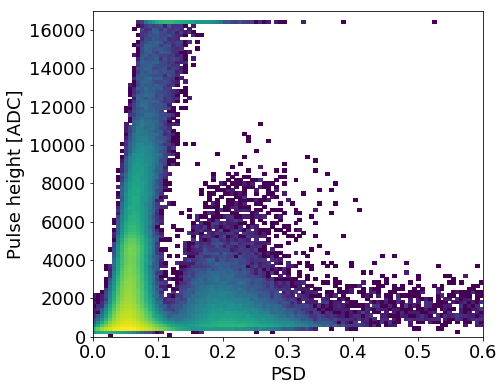

In [8]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

xrange = [0.,0.6]
yrange = [0.,17000.]

par = plt.hist2d(1./data['ndet_PSD'].loc[mask], \
                 data['ndet_PH'].loc[mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(xrange[0],xrange[1],100),\
                        np.linspace(yrange[0],yrange[1],100) ) )


plt.xlabel('PSD')
plt.ylabel('Pulse height [ADC]')

plt.savefig('Plots/PSDAnalysis/inverse_psd_vs_ph_ch0_no_cuts.png',\
           dpi=200, bbox_inches='tight')
    

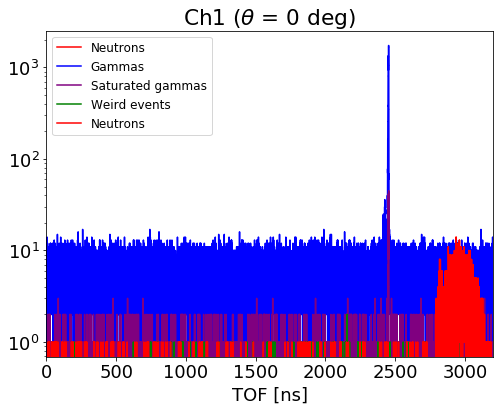

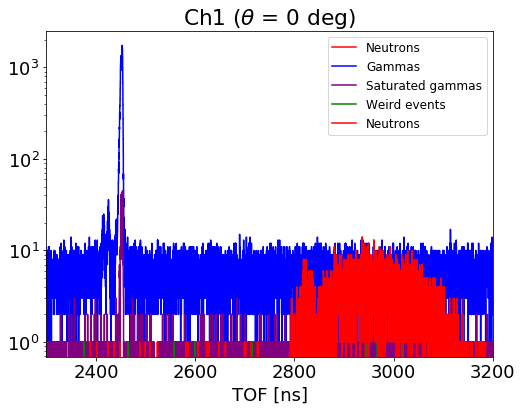

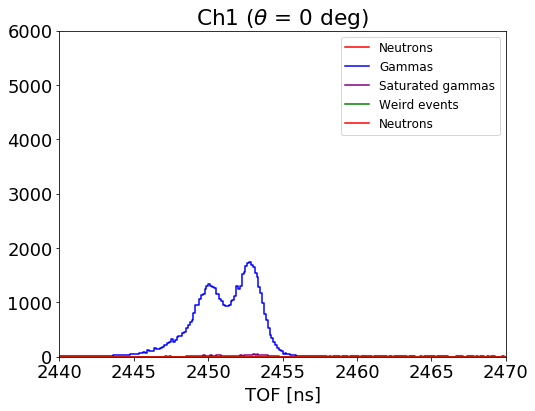

In [9]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

mask = (data['ndet_ch']==0.)
nbins = 25601

weird_evt_cut = mask & \
            (data['ndet_PSD']>0.) & \
            (data['ndet_PSD']< 2.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 15000.)

neutron_cut = mask & \
            (data['ndet_PSD']>2.) & \
            (data['ndet_PSD']< 7.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 10000.)

gamma_cut = mask & \
            (data['ndet_PSD']>7.) & \
            (data['ndet_PSD']< 25.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 10000.)

saturated_gamma_cut = mask & (data['ndet_PH'] > 16000.)


hweird = hl.hist(data['ndet_tof'].loc[weird_evt_cut],\
                bins=np.linspace(0.,3200.,nbins))

hneutron = hl.hist(data['ndet_tof'].loc[neutron_cut],\
                bins=np.linspace(0.,3200.,nbins))

hgamma = hl.hist(data['ndet_tof'].loc[gamma_cut],\
                bins=np.linspace(0.,3200.,nbins))

hsatgamma = hl.hist(data['ndet_tof'].loc[saturated_gamma_cut],\
                bins=np.linspace(0.,3200.,nbins))


hl.plot1d(hneutron, color='r', label='Neutrons')
hl.plot1d(hgamma, color='b', label='Gammas')
hl.plot1d(hsatgamma, color=(0.5,0.,0.5), label='Saturated gammas')
hl.plot1d(hweird, color='g', label='Weird events')
hl.plot1d(hneutron, color='r', label='Neutrons')

plt.xlabel('TOF [ns]')
plt.legend(fontsize=12)
#plt.ylim(0.,100.)

plt.xlim(2300.,3200.)
plt.xlim(0.,3200.)
plt.yscale('log')

plt.title(r'Ch1 ($\theta$ = 0 deg)')

plt.savefig('Plots/PSDAnalysis/psd_spectrum_ch0_full.png',\
           dpi=200,bbox_inches='tight')




plt.figure(2)

hl.plot1d(hneutron, color='r', label='Neutrons')
hl.plot1d(hgamma, color='b', label='Gammas')
hl.plot1d(hsatgamma, color=(0.5,0.,0.5), label='Saturated gammas')
hl.plot1d(hweird, color='g', label='Weird events')
hl.plot1d(hneutron, color='r', label='Neutrons')

plt.xlabel('TOF [ns]')
plt.legend(fontsize=12)
#plt.ylim(0.,100.)

plt.xlim(2300.,3200.)
plt.yscale('log')

plt.title(r'Ch1 ($\theta$ = 0 deg)')

plt.savefig('Plots/PSDAnalysis/psd_spectrum_ch0_time_cut.png',\
           dpi=200,bbox_inches='tight')

plt.figure(3)

hl.plot1d(hneutron, color='r', label='Neutrons')
hl.plot1d(hgamma, color='b', label='Gammas')
hl.plot1d(hsatgamma, color=(0.5,0.,0.5), label='Saturated gammas')
hl.plot1d(hweird, color='g', label='Weird events')
hl.plot1d(hneutron, color='r', label='Neutrons')

plt.xlabel('TOF [ns]')
plt.legend(fontsize=12)
plt.ylim(0.,6000.)

plt.xlim(2440.,2470.)
# plt.yscale('log')

plt.title(r'Ch1 ($\theta$ = 0 deg)')

plt.savefig('Plots/PSDAnalysis/psd_spectrum_ch0_time_cut_gamma_flash.png',\
           dpi=200,bbox_inches='tight')



# Investigate the substructure in the gamma TOF spectrum

In [10]:
def Gaussian( x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def TripleGaussianSameSigma(x, A1, mu1, sig1, A2, mu2, A3, mu3):
    return Gaussian( A1, mu1, sig1) + \
            Gaussian( A2, mu2, sig1) + \
            Gaussian( A3, mu3, sig1)

In [11]:
mask = (data['ndet_ch']==0.)

print('Cut survival fraction: {:4.4}'.format(np.sum(mask)/len(mask)))

gamma_cut = mask & \
            (data['ndet_PSD']>7.) & \
            (data['ndet_PSD']< 25.) & \
            (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )) & \
            (data['ndet_PH'] < 10000.)

nbins = 12801*3

hgamma = hl.hist(data['ndet_tof'].loc[gamma_cut],\
                bins=np.linspace(0.,3200.,nbins))




Cut survival fraction: 0.07008


No handles with labels found to put in legend.


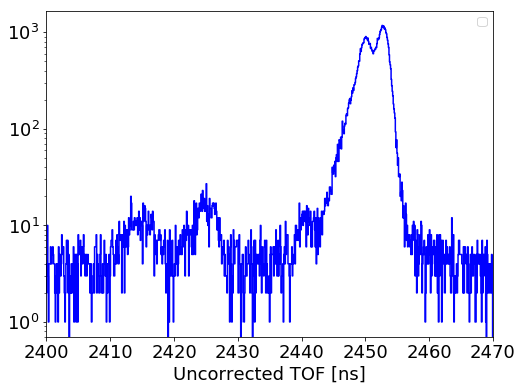

In [12]:
plt.xlabel('Uncorrected TOF [ns]')
plt.legend(fontsize=12)
#plt.ylim(0.,6000.)

plt.xlim(2400.,2470.)
plt.yscale('log')

hl.plot1d(hgamma, color='b', label='Gammas')




A: 11.26,	mu: 2414.79,	sig: 2.981
A: 16.76,	mu: 2425.0,	sig: 1.875
A: 12.21,	mu: 2440.76,	sig: 1.629
A: 1.145e+04,	mu: 2460.93,	sig: 4.664
A: 870.3,	mu: 2450.14,	sig: 1.088
A: 1.159e+03,	mu: 2452.78,	sig: 0.8452


(2440.0, 2460.0)

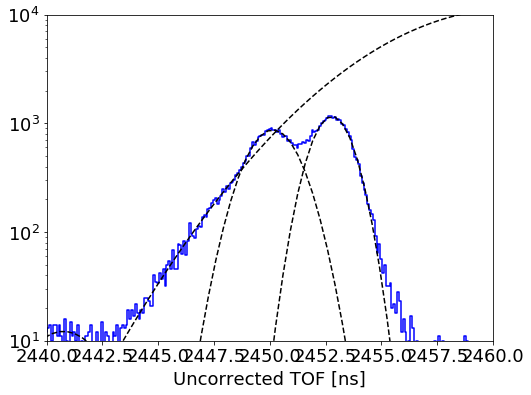

In [13]:
bc = GetBinCenters(hgamma)
vals = hgamma.values

peak_fits = []

windows = [ [2412.,2419.],
           [2423.,2428.],
           [2438.,2442.],
           [2445.,2448.],
           [2449.,2451.],
           [2452.,2454.] ]


hl.plot1d(hgamma, color='b', label='Gammas')

for window in windows:
    fitmask = (bc > window[0]) & (bc < window[1])
    try:
        p,pcov = opt.curve_fit(Gaussian, bc[fitmask], vals[fitmask], \
                              p0 = ( np.max(vals[fitmask]), window[0]+2., 1.) )


        xfit = np.linspace(0.,3200.,3200*3)
        yfit = Gaussian( xfit, p[0], p[1], p[2] )
        plt.plot(xfit,yfit,'--k')
        
        peak_fits.append(p[1])
        
    except RuntimeError as e:
        print(e)
        
    print('A: {:4.4},\tmu: {:6.6},\tsig: {:4.4}'.format(p[0],p[1],p[2]))
    
    

plt.xlabel('Uncorrected TOF [ns]')
# plt.legend(fontsize=12)

plt.xlim(2405.,2460.)
plt.ylim(10.,10000.)
plt.yscale('log')

plt.xlim(2440.,2460.)




In [14]:
def TOF_vs_distance( distance, energy ):
    # Energy must be given in units of MeV
    distance = distance # m
    c = 3e8 # m/s
    m_N = 939.56563 # MeV
    
    TOF = distance / ( c*np.sqrt( 1 - ( 1 / (energy/m_N + 1) )**2  ) )
    return TOF
    
    
def DistanceFromProtonTOF( TOF, energy ):
    TOF = TOF # ns
    c = 3e8 # m/s
    m_p = 938.272 # MeV/c^2
    
    distance = (TOF * 1.e-9) * \
                (c * np.sqrt( 1 - (1 / (energy/m_p + 1))**2 ) )
    return distance

In [15]:
distance_upstream = []

for peak in peak_fits:
    
    TOF = peak_fits[-1] - peak
    
    distance_upstream.append( DistanceFromProtonTOF(TOF, 7.) )
    
print(distance_upstream)

[1.3846781036823568, 1.0123929580549964, 0.4383353427875094, -0.2969988083135919, 0.09633284498933892, 0.0]


ch0
	A: 10.71,	mu: 2414.8,	sig: 3.24
	A: 15.88,	mu: 2424.9,	sig: 2.051
	A: 11.95,	mu: 2440.78,	sig: 2.009
	A: 857.5,	mu: 2450.15,	sig: 1.073
	A: 1.129e+03,	mu: 2452.79,	sig: 0.8411
ch1
	A: 47.02,	mu: 2411.23,	sig: 2.172
	A: 30.97,	mu: 2421.41,	sig: 1.587
	A: 14.02,	mu: 2436.82,	sig: 1.287
	A: 836.4,	mu: 2446.57,	sig: 0.9818
	A: 1.124e+03,	mu: 2449.19,	sig: 0.8802
ch2
	A: 39.88,	mu: 2411.15,	sig: 2.174
	A: 14.59,	mu: 2421.24,	sig: 1.846
	A: 11.14,	mu: 2437.05,	sig: 1.35
	A: 821.2,	mu: 2446.52,	sig: 0.9999
	A: 1.067e+03,	mu: 2449.19,	sig: 0.8832
ch3
	A: 5.228,	mu: 2422.26,	sig: 4.381
	A: 3.465,	mu: 2431.44,	sig: 6.872
	A: 10.37,	mu: 2447.67,	sig: 1.071
	A: 650.6,	mu: 2457.32,	sig: 1.017
	A: 866.8,	mu: 2460.01,	sig: 0.8461
ch4
	A: 4.336,	mu: 2406.92,	sig: 3.942
	A: 2.963,	mu: 2416.76,	sig: 4.158
	A: 8.909,	mu: 2432.53,	sig:  1.2
	A: 521.4,	mu: 2442.13,	sig: 0.9095
	A: 696.4,	mu: 2444.72,	sig: 0.8962
ch5
	A: 5.402,	mu: 2408.49,	sig: 3.686
	A: 3.449,	mu: 2419.1,	sig: 3.148
	A: 8.999,	mu: 24

/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log10


ch10
	A:  0.0,	mu:    0.0,	sig:  0.0
	A:  0.0,	mu:    0.0,	sig:  0.0
	A:  0.0,	mu:    0.0,	sig:  0.0
	A:  0.0,	mu:    0.0,	sig:  0.0
	A:  0.0,	mu:    0.0,	sig:  0.0
ch16
	A: 11.16,	mu: 2418.71,	sig: 3.177
	A: 7.951,	mu: 2428.9,	sig: 2.179
	A: 9.978,	mu: 2444.57,	sig: 1.124
	A: 803.9,	mu: 2454.11,	sig: 1.053
	A: 1.13e+03,	mu: 2456.74,	sig: 0.8239
ch17
	A: 13.24,	mu: 2412.58,	sig: 2.419
	A: 6.079,	mu: 2422.57,	sig: 2.844
	A: 8.348,	mu: 2438.48,	sig: 1.157
	A: 740.4,	mu: 2447.96,	sig: 0.9992
	A: 1.063e+03,	mu: 2450.54,	sig: 0.8813
ch18
	A: 11.48,	mu: 2398.76,	sig: 3.084
	A: 7.039,	mu: 2408.97,	sig: 3.041
	A: 8.635,	mu: 2424.91,	sig: 1.429
	A: 831.4,	mu: 2434.33,	sig: 1.061
	A: 1.154e+03,	mu: 2436.96,	sig: 0.8391
ch19
	A: 8.046,	mu: 2410.48,	sig: 3.859
	A: 13.04,	mu: 2421.02,	sig: 1.767
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
	A: 13.04,	mu: 2421.02,	sig: 1.767
	A: 851.9,	mu: 2445.92,	sig: 0.9796
	A: 1.169e+03,	mu: 2448.57,	sig: 0.8805
ch20
	A: 5.

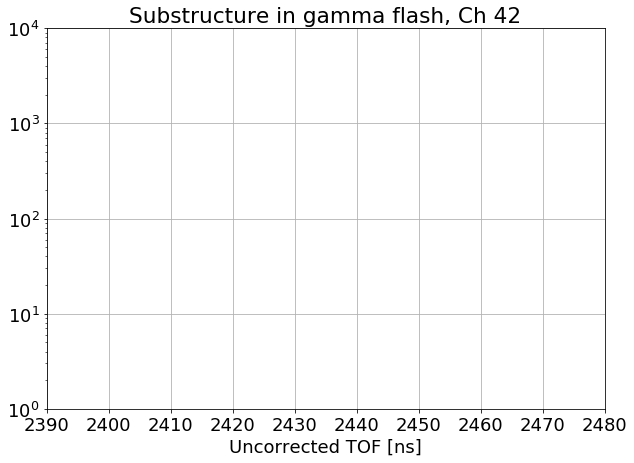

In [79]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,7)

# Will be a list of lists
gamma_flash_peak_fits = []

with PdfPages('Plots/PSDAnalysis/gamma_flash_with_fits_all_channels.pdf') as pdf: 

    for ch in channel_names:
        plt.clf()
        print(ch)
        cfg = config_params[ch]

        thisch = float(ch[2:])

        # Create gamma histogram
        mask = (data['ndet_ch']==thisch)
        #print('Cut survival fraction: {:4.4}'.format(np.sum(mask)/len(mask)))
        gamma_cut = mask & \
                    (data['ndet_PSD']>10.) & \
                    (data['ndet_PSD']< 25.) & \
                    (data['ndet_PH'] > pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )*2.) & \
                    (data['ndet_PH'] < 10000.)

        nbins = 12801*3
        hgamma = hl.hist(data['ndet_tof'].loc[gamma_cut],\
                        bins=np.linspace(0.,3200.,nbins))



        bc = GetBinCenters(hgamma)
        vals = hgamma.values

        peak_fits = []
        height_fits = []

        # windows = [ [2412.,2419.],
        #            [2423.,2428.],
        #            [2438.,2442.],
        #            [2445.,2448.],
        #            [2449.,2451.],
        #            [2452.,2454.] ]

        windows = [ [2408.,2417.],
                   [2418.,2425.],
                   [2436.,2438.],
                   [2445.5,2447.],
                   [2449.,2453.] ]

        offset = bc[ np.argmax(hgamma.values) ] - 2449.21

        #print(bc[ np.argmax(hgamma.values) ])
        #print(offset)


        hl.plot1d(hgamma, color='b', label='Gammas')
        
        thisch_peak_fits = []

        for window in windows:

            if np.abs(offset) < 100.:
                fitmask = (bc > window[0]+offset) & (bc < window[1]+offset)
                try:
                    p,pcov = opt.curve_fit(Gaussian, bc[fitmask], vals[fitmask], \
                                          p0 = ( np.max(vals[fitmask]), window[0]+offset, 1.) )


                    xfit = np.linspace(0.,3200.,3200*3)
                    yfit = Gaussian( xfit, p[0], p[1], p[2] )
                    plt.plot(xfit,yfit,'--k')

                    peak_fits.append(p[1])
                    height_fits.append(p[0])


                except RuntimeError as e:
                    print(e)
            else:
                p = [0.,0.,0.]

            print('\tA: {:4.4},\tmu: {:6.6},\tsig: {:4.4}'.format(p[0],p[1],p[2]))
            
            thisch_peak_fits.append(p[1])
        
        gamma_flash_peak_fits.append(thisch_peak_fits)


        plt.xlabel('Uncorrected TOF [ns]')
        # plt.legend(fontsize=12)

        plt.xlim(2390.,2480.)
        plt.ylim(1.,10000.)
        plt.yscale('log')
        plt.grid()



        distance_upstream = []
        for peak in peak_fits:
            TOF = peak_fits[-1] - peak
            distance_upstream.append( DistanceFromProtonTOF(TOF, 7.) )
        #print(distance_upstream)

        max_height = 10**(1.03 * np.log10( np.max(hgamma.values)) )
        for i,distance in enumerate(distance_upstream):

            label_height = 1.5* height_fits[i]

            plt.gca().text(peak_fits[i],label_height,\
                        '{:4.4} cm'.format(distance*100.),\
                       fontsize=14.,rotation='vertical',\
                        horizontalalignment='center',\
                      verticalalignment='bottom')

        plt.title('Substructure in gamma flash, Ch {}'.format(int(thisch)))
        pdf.savefig()
        
# Write the peak fit values to a file
with open('analysis_data/gamma_flash_peak_fits_30180.csv','w') as outfile:
    for i,ch in enumerate(channel_names):
        outfile.write('{},{},{},{},{},{}\n'.format(\
                                                ch[2:],\
                                                gamma_flash_peak_fits[i][0],\
                                                gamma_flash_peak_fits[i][1],\
                                                gamma_flash_peak_fits[i][2],\
                                                gamma_flash_peak_fits[i][3],\
                                                gamma_flash_peak_fits[i][4]))
        
    

# plt.xlim(2440.,2460.)

# Train cuts on PSD distributions

In [54]:
def Gaussian( x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def TwoGaussian( x, A1, mu1, sig1, A2, mu2, sig2):
    return A1*np.exp(-(x-mu1)**2/(2*sig1**2)) + \
            A2*np.exp(-(x-mu2)**2/(2*sig2**2))


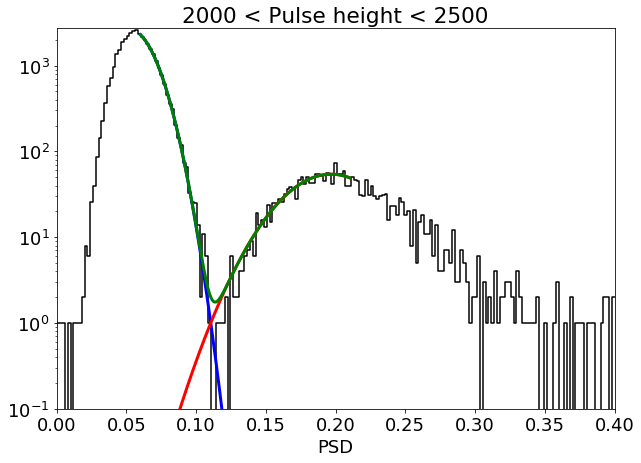

In [55]:
# def GaussianEdgeFinderPSD( data ):
    
    # Take slices in pulse height, fit them to a gaussian
chmask = (data['ndet_ch']==1.)
    
ph_slice_cut = chmask & \
                (data['ndet_PH']>2000.) & \
                (data['ndet_PH']<2500.)

cutdata = data.loc[ph_slice_cut]

hpsd = hl.hist(1./cutdata['ndet_PSD'], bins = np.linspace(0.,0.4,200))

hl.plot1d( hpsd, color='k')

plt.xlabel('PSD')
plt.title('2000 < Pulse height < 2500')
plt.xlim(0.,0.4)
plt.ylim(0.1,np.max(hpsd.values)*1.05)
plt.yscale('log')


bincenters = (hpsd.bins[0][:-1] + hpsd.bins[0][1:])/2.


neutron_fit_cut = (bincenters > 0.12) & \
                    (bincenters < 0.21)

gamma_fit_cut = (bincenters > 0.06) & \
                (bincenters < 0.12)



gammap,gammacov = opt.curve_fit( Gaussian, bincenters[gamma_fit_cut],\
                                hpsd.values[gamma_fit_cut], \
                               p0 = (4000.,0.05,0.02))

neutronp,neutroncov = opt.curve_fit( Gaussian, bincenters[neutron_fit_cut],\
                                hpsd.values[neutron_fit_cut], \
                               p0 = (200.,0.2,0.03))

twop, twocov = opt.curve_fit( TwoGaussian,\
                            bincenters[gamma_fit_cut|neutron_fit_cut],\
                                hpsd.values[gamma_fit_cut|neutron_fit_cut], \
                            p0 = (4000.,0.05,0.02,200.,0.2,0.03))



# xfit = np.linspace(0.,0.4,500)
# ygamma = Gaussian(xfit, gammap[0], gammap[1], gammap[2])
# yneutrons = Gaussian(xfit, neutronp[0], neutronp[1], neutronp[2])



xfit = np.linspace(0.06,0.21,500)

ytwo = TwoGaussian( xfit, twop[0],twop[1],twop[2],\
                           twop[3],twop[4],twop[5])

ygamma = Gaussian(xfit, twop[0],twop[1],twop[2])
yneutrons = Gaussian(xfit, twop[3],twop[4],twop[5])

plt.plot(xfit,ygamma,'-b',linewidth=3)
plt.plot(xfit,yneutrons,'-r',linewidth=3)
plt.plot(xfit,ytwo,'-g',linewidth=3)

plt.savefig('Plots/PSDAnalysis/two_gaussian_fit_ch1.png',\
           dpi=200,bbox_inches='tight')


    

In [64]:
def FitEdgesWithDoubleGaussian( data, channel, maximum = 6000. ):
    
    chmask = (data['ndet_ch']==channel)
    
    ph_slices = np.transpose( \
                    np.array([np.arange(1000.,maximum-500.,step=500.), \
                                 np.arange(1500,maximum,step=500.)]))
    
    
    
    edge_width = 3.
    
    gamma_edge = []
    neutron_edge = []
    slice_center = []
    
    for this_slice in ph_slices:
        
        print("Slice: {}".format(this_slice))
        
        ph_slice_cut = chmask & \
                (data['ndet_PH']>this_slice[0]) & \
                (data['ndet_PH']<this_slice[1])
        
        cutdata = data.loc[ph_slice_cut]

        hpsd = hl.hist(1./cutdata['ndet_PSD'], bins = np.linspace(0.,0.4,200))
        
        bincenters = (hpsd.bins[0][:-1] + hpsd.bins[0][1:])/2.

        neutron_fit_cut = (bincenters > 0.12) & \
                            (bincenters < 0.21)

        gamma_fit_cut = (bincenters > 0.06) & \
                        (bincenters < 0.12)
        try:
            twop, twocov = opt.curve_fit( TwoGaussian,\
                                bincenters[gamma_fit_cut|neutron_fit_cut],\
                                    hpsd.values[gamma_fit_cut|neutron_fit_cut], \
                                        p0 = (4000.,0.05,0.02,200.,0.2,0.03))
        except RuntimeError as e:
            print(e)
        
        #print(twop)
        
        gamma_edge.append( twop[1] + edge_width*twop[2] )
        neutron_edge.append( twop[4] - edge_width*twop[5] )
        slice_center.append((this_slice[0]+this_slice[1])/2.)

        
        
        
    return slice_center, gamma_edge, neutron_edge



###########################################################################
###########################################################################

def FitGammaEdgeGaussian( data, channel, maximum = 12000., edge_sigma =3. ):
    
    chmask = (data['ndet_ch']==channel)
    
    ph_slices = np.transpose( \
                    np.array([np.arange(1000.,maximum-500.,step=500.), \
                                 np.arange(1500,maximum,step=500.)]))
    
    
    
    edge_sigma = 4.
    
    gamma_edge = []
    slice_center = []
    
    for this_slice in ph_slices:
        
        #print("Slice: {}".format(this_slice))
        
        ph_slice_cut = chmask & \
                (data['ndet_PH']>this_slice[0]) & \
                (data['ndet_PH']<this_slice[1])
        
        cutdata = data.loc[ph_slice_cut]

        hpsd = hl.hist(1./cutdata['ndet_PSD'], bins = np.linspace(0.,0.4,200))
        
        bincenters = (hpsd.bins[0][:-1] + hpsd.bins[0][1:])/2.


        gamma_fit_cut = (bincenters > 0.04) & \
                        (bincenters < 0.12)
        try:
            twop, twocov = opt.curve_fit( Gaussian,\
                                bincenters[gamma_fit_cut],\
                                    hpsd.values[gamma_fit_cut], \
                                        p0 = (4000.,0.075,0.02))
        except RuntimeError as e:
            print(e)
            continue
        
        #print(twop)
        
        gamma_edge.append( twop[1] + edge_sigma*np.abs(twop[2]) )
        slice_center.append((this_slice[0]+this_slice[1])/2.)

        
        
        
    return slice_center, gamma_edge


In [65]:
slice_centers, gamma_edge, neutron_edge = \
                    FitEdgesWithDoubleGaussian(data, channel=1,maximum=8000.)


single_slice_centers, single_gamma_edge = \
                    FitGammaEdgeGaussian(data, channel=1,maximum=15000.)




Slice: [1000. 1500.]
Slice: [1500. 2000.]
Slice: [2000. 2500.]
Slice: [2500. 3000.]
Slice: [3000. 3500.]
Slice: [3500. 4000.]
Slice: [4000. 4500.]
Slice: [4500. 5000.]
Slice: [5000. 5500.]
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Slice: [5500. 6000.]
Slice: [6000. 6500.]
Slice: [6500. 7000.]
Slice: [7000. 7500.]


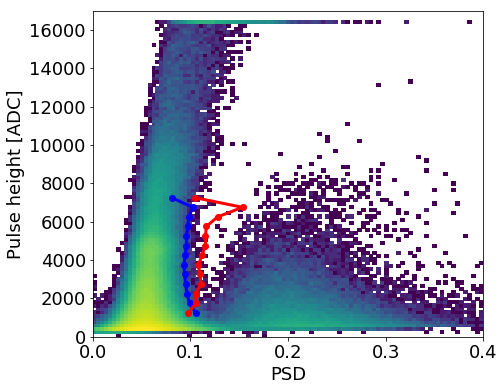

In [66]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

mask = (data['ndet_ch']==1.)
    

xrange = [0.,0.4]
yrange = [0.,17000.]

par = plt.hist2d(1./np.abs(data['ndet_PSD'].loc[mask]), \
                 data['ndet_PH'].loc[mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(xrange[0],xrange[1],100),\
                        np.linspace(yrange[0],yrange[1],100) ) )


plt.xlabel('PSD')
plt.ylabel('Pulse height [ADC]')

# plt.savefig('Plots/PSDAnalysis/psd_vs_ph_ch0_no_cuts.png',\
#            dpi=200, bbox_inches='tight')

plt.plot(gamma_edge,slice_centers,'-ob',linewidth=3)
#plt.plot(single_gamma_edge, single_slice_centers, '-ob', linewidth=2)

plt.plot(neutron_edge,slice_centers,'-or',linewidth=3)

plt.savefig('Plots/PSDAnalysis/psd_vs_pulse_height_with_edge_finding.png',\
           dpi=200,bbox_inches='tight')


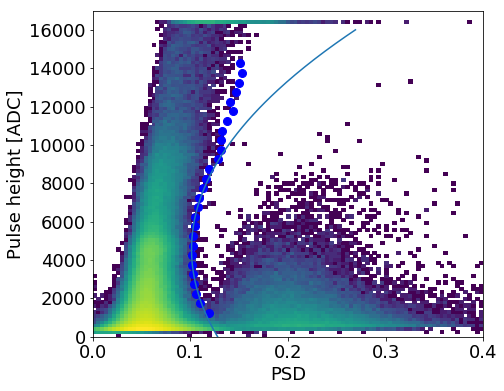

In [67]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)

xrange = [0.,0.4]
yrange = [0.,17000.]

par = plt.hist2d(1./np.abs(data['ndet_PSD'].loc[mask]), \
                 data['ndet_PH'].loc[mask], \
                 norm=mpl.colors.LogNorm(), \
                 cmap=mpl.cm.viridis,\
                bins = (np.linspace(xrange[0],xrange[1],100),\
                        np.linspace(yrange[0],yrange[1],100) ) )


plt.xlabel('PSD')
plt.ylabel('Pulse height [ADC]')


plt.plot(single_gamma_edge, single_slice_centers, 'ob', markersize=8)




# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0.01,0.4)
# plt.ylim(100.,16000.)

quadmask = np.array(single_slice_centers)<8000.

p = np.polyfit(np.array(single_slice_centers)[quadmask], \
               np.array(single_gamma_edge)[quadmask],\
               2)

xfit = np.linspace(0.,16000.,200)
yfit = p[0] * xfit**2 + p[1]*xfit + p[2]

plt.plot(yfit,xfit)

plt.savefig('Plots/PSDAnalysis/psd_vs_pulse_height_with_edge_finding_just_gamma.png',\
           dpi=200,bbox_inches='tight')


ch0
ch1
ch2
ch3
ch4
ch5
ch6
ch7
ch8
ch9
ch10
ch16
ch17
ch18
ch19
ch20
ch21
ch27
ch30
ch42


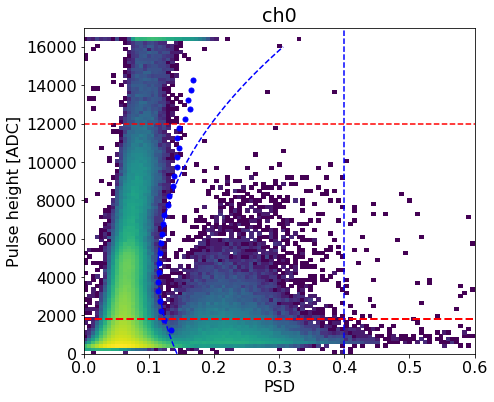

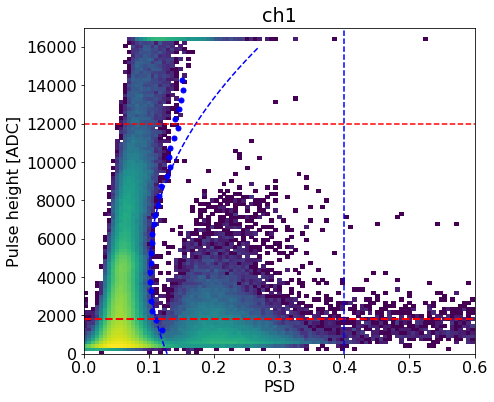

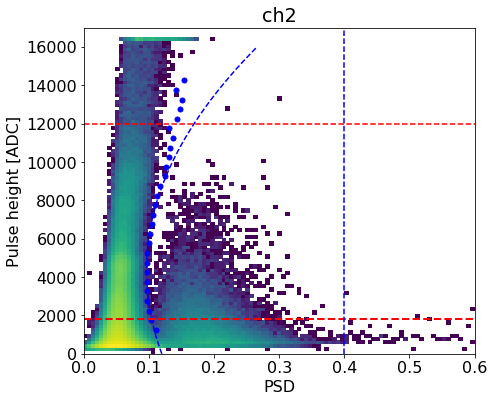

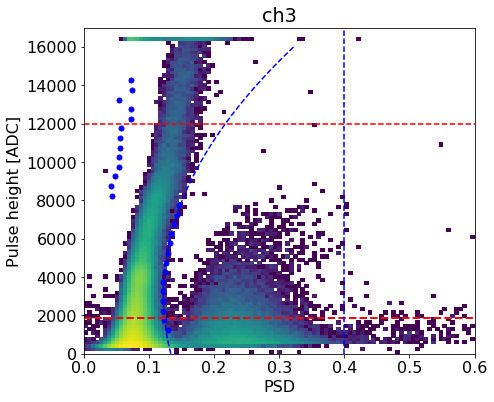

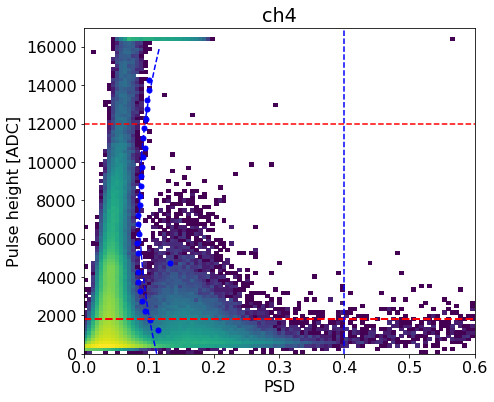

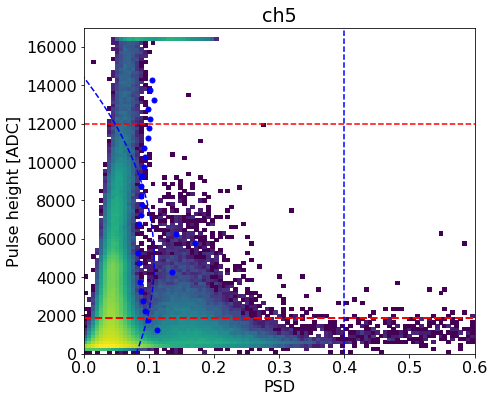

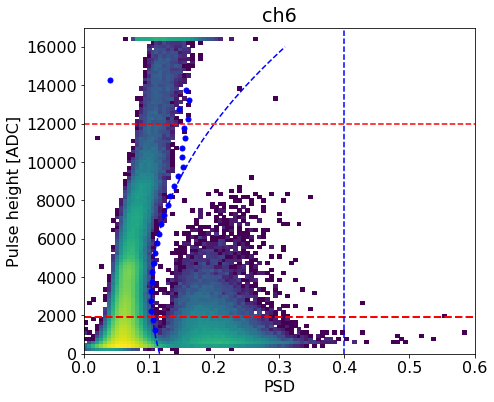

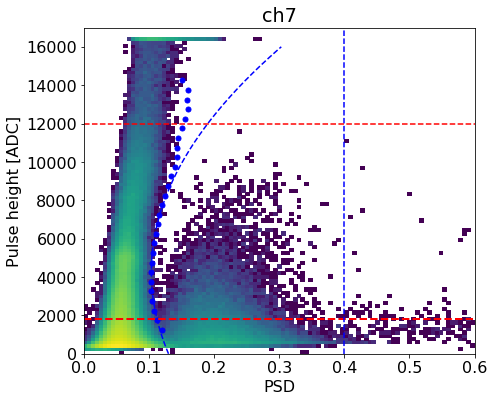

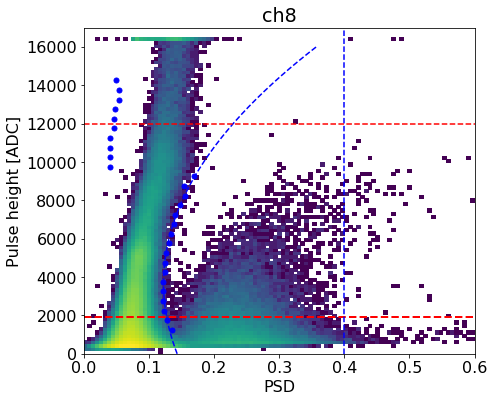

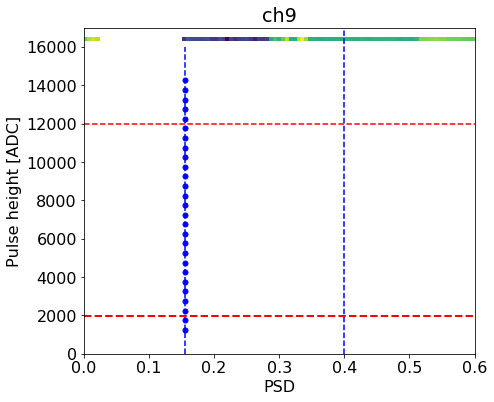

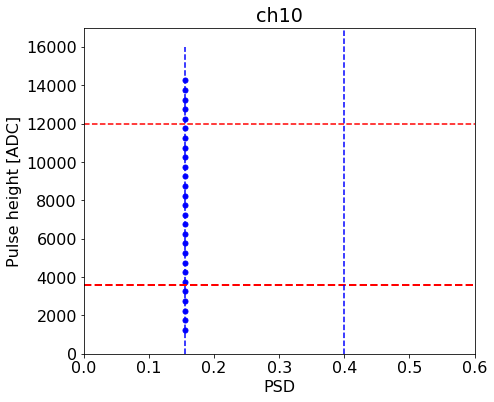

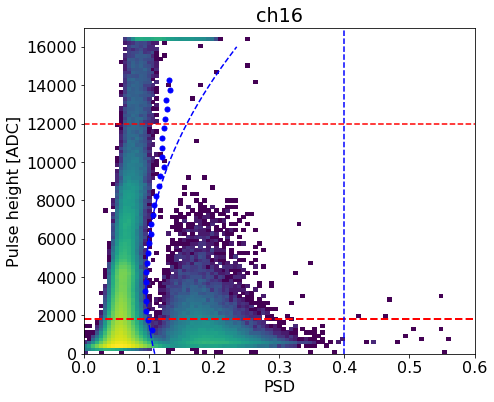

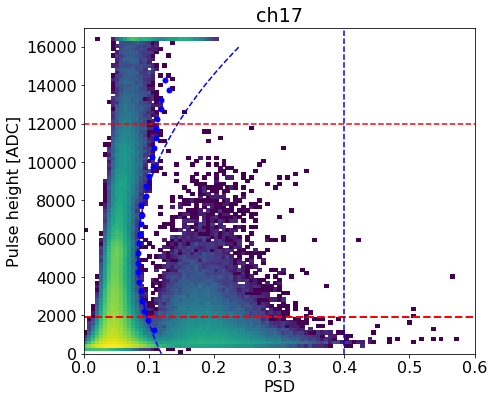

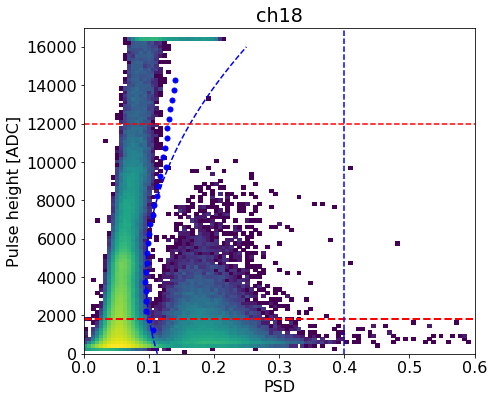

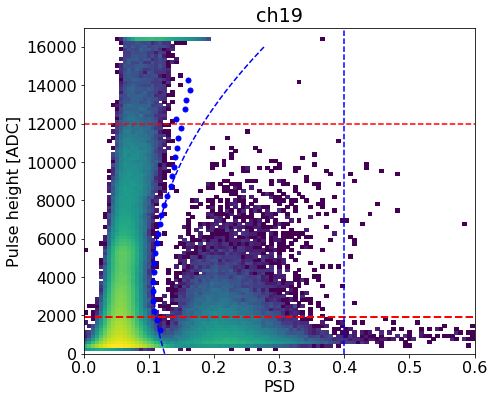

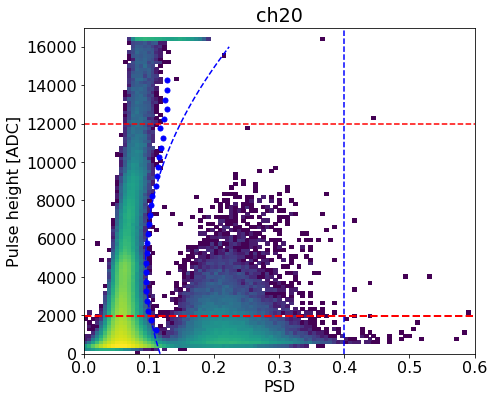

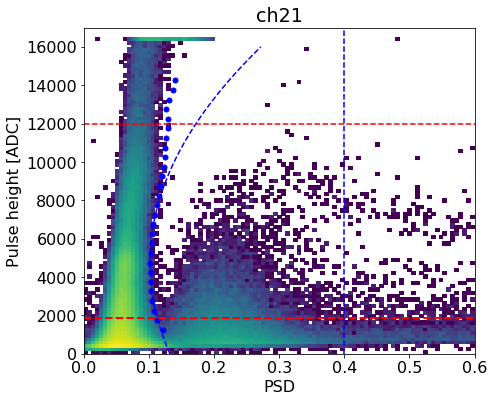

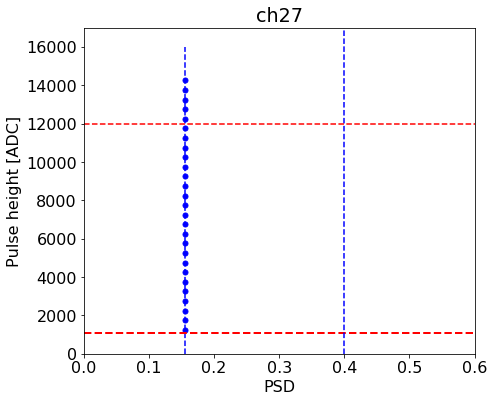

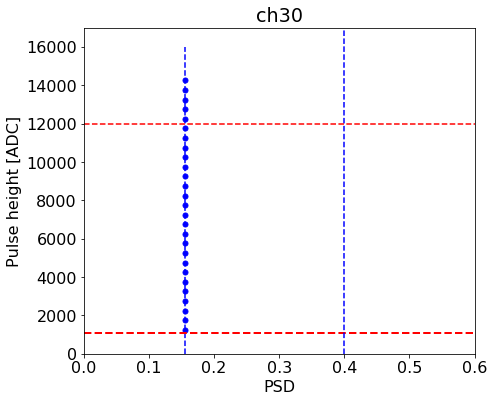

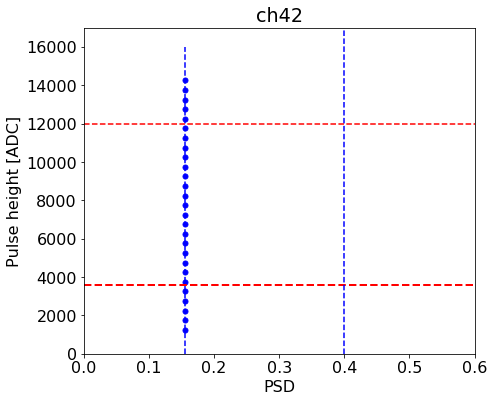

In [69]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (7,6)

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('inverse_psd_vs_pulse_height_with_4sig_cut.pdf') as pdf: 
    
    # Do the fits across all channels

    gamma_cut_parameters = {}

    for thisch in channel_names:
        print(thisch)
        cfg = config_params[chname]

        chnum = float(thisch[2:])

        mask = (data['ndet_ch']==chnum)

        single_slice_centers, single_gamma_edge = \
                        FitGammaEdgeGaussian(data, channel=chnum,maximum=15000.)

        quadmask = np.array(single_slice_centers)<8000.

        p = np.polyfit(np.array(single_slice_centers)[quadmask], \
                       np.array(single_gamma_edge)[quadmask],\
                       2)

        plt.figure(int(chnum))

        xrange = [0.,0.6]
        yrange = [0.,17000.]

        par = plt.hist2d(1./np.abs(data['ndet_PSD'].loc[mask]), \
                         data['ndet_PH'].loc[mask], \
                         norm=mpl.colors.LogNorm(), \
                         cmap=mpl.cm.viridis,\
                        bins = (np.linspace(xrange[0],xrange[1],100),\
                                np.linspace(yrange[0],yrange[1],100) ) )

        plt.xlabel('PSD')
        plt.ylabel('Pulse height [ADC]')
        plt.title('{}'.format(thisch))

        xfit = np.linspace(0.,16000.,200)
        yfit = p[0] * xfit**2 + p[1]*xfit + p[2]

        plt.plot(yfit,xfit,'--b')
        plt.plot(single_gamma_edge, single_slice_centers, 'ob', markersize=5)

        gamma_cut_parameters[thisch] = p

        cfg = config_params[thisch]
        ph_cut = pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )
        # Plot the 1/2Cs threshold
        plt.plot( np.linspace(0.,1.,10),\
                np.ones(10) * ph_cut * 2., '--r', \
                linewidth=2, label='PH cut (1x Cs)')

        plt.plot(np.ones(10)*0.4,np.linspace(yrange[0],yrange[1],10),'--b')

        plt.plot(np.linspace(0.,1.,10), np.ones(10)*12000.,'--r')


        pdf.savefig()
        #plt.savefig('Plots/PSDAnalysis/{}_inverse_psd_vs_pulse_height_with_4sig_cut.png'.format(thisch),\
        #           dpi=200,bbox_inches='tight')



In [71]:
def WritePSDCutToFile( filename, parameter_dict ):
    with open(filename,'w') as outputfile:
        outputfile.write('Channel,a,b,c\n')
        for ch, params in parameter_dict.items():
            outputfile.write('{},{:5.5},{:5.5},{:5.5}\n'.format(\
                        ch[2:], params[0], params[1], params[2]))
            
        
    

        

In [72]:
WritePSDCutToFile('analysis_data/30180_psd_cut_parameters.csv', gamma_cut_parameters)


# Using these PSD cuts

In [19]:
def GetPSDCutMask( dataframe, cut_params ):
    
    xfit = np.linspace(0.,16000.,200)
    
#     cut_params = cut_dict[channel]
    
    quadratic_PH = (cut_params[0]*dataframe['ndet_PH']**2 + \
                    cut_params[1]*dataframe['ndet_PH'] + \
                    cut_params[2])
    
    inverse_psd = 1./dataframe['ndet_PSD']
    
    mask = ( inverse_psd > quadratic_PH ) & (inverse_psd < 0.4)

    return mask
    
    
    
    

8959761
8959761


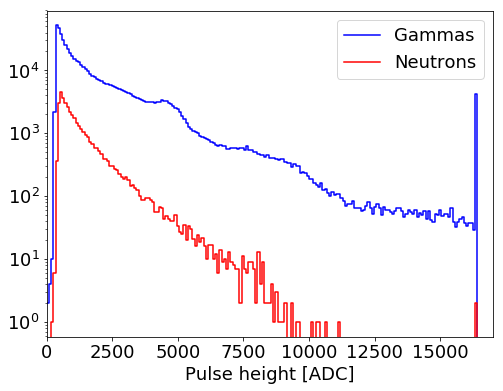

In [20]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

thisch = 'ch1'

chmask = (data['ndet_ch']==1.)

print(len(chmask))

psdmask = GetPSDCutMask( data, gamma_cut_parameters[thisch] )

print(len(psdmask))

hph_gamma = hl.hist(data['ndet_PH'].loc[chmask&np.invert(psdmask)],\
                     bins=np.linspace(0.,17000.,200))

hph_neutron = hl.hist(data['ndet_PH'].loc[chmask&psdmask],\
                     bins=np.linspace(0.,17000.,200))


hl.plot1d(hph_gamma,color='b', label='Gammas')
hl.plot1d(hph_neutron,color='r', label='Neutrons')

plt.xlim(0.,17000.)
plt.yscale('log')

plt.xlabel('Pulse height [ADC]')
plt.legend()

plt.savefig('Plots/PSDAnalysis/pulse_height_spectrum_ch1_quadratic_cut.png',\
           dpi=200,bbox_inches='tight')






Number of counts between 1/2 and 1x: 11960.0
Number of counts above 1x: 7695.0
Ratio between/above: 1.554


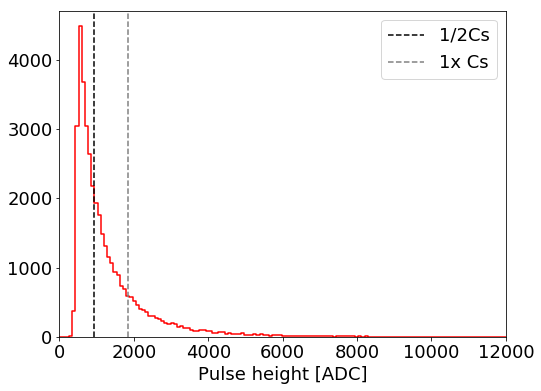

In [21]:
hl.plot1d(hph_neutron,color='r')

plotheight = np.max(hph_neutron.values)*1.05

bincenters = (hph_neutron.bins[0][1:]+hph_neutron.bins[0][:-1])/2.


plt.xlim(0.,12000.)
plt.ylim(0.,plotheight)

plt.xlabel('Pulse height [ADC]')

cfg = config_params[thisch]
ph_cut = pulse_height_cut_val( cfg['ngain_m'], cfg['ngain_b'] )

plt.plot( np.ones(10)*ph_cut, np.linspace(0.,plotheight,10), '--k', \
         label='1/2Cs')
plt.plot( np.ones(10)*ph_cut*2, np.linspace(0.,plotheight,10), '--',\
         color=(0.5,0.5,0.5),\
         label='1x Cs')

plt.legend()

between_mask = (bincenters > ph_cut)&(bincenters < ph_cut*2)
print('Number of counts between 1/2 and 1x: {}'.format(\
                    np.sum( hph_neutron.values[between_mask] )))
                                                       
beyond_mask = (bincenters > ph_cut*2)
print('Number of counts above 1x: {}'.format(\
                    np.sum( hph_neutron.values[beyond_mask] ) ))                                                      
                                                    
print('Ratio between/above: {:4.4}'.format(\
                np.sum( hph_neutron.values[between_mask] ) / \
                np.sum( hph_neutron.values[beyond_mask] ) ))

plt.savefig('Plots/PSDAnalysis/pulse_height_spectrum_ch1_neutrons_w_Cs_thresholds.png',\
           dpi=200,bbox_inches='tight')


# Neutron detector efficiencies

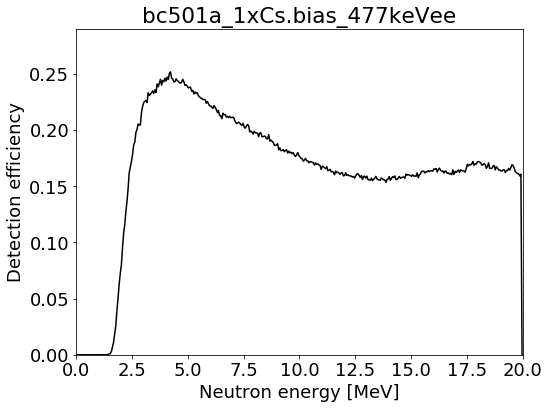

In [22]:
ndet_eff = np.genfromtxt('collin_ndet_efficiencies.txt')

plt.plot(ndet_eff[:,0], ndet_eff[:,1],'-k',label='1x Cs')

plt.xlabel('Neutron energy [MeV]')

plt.ylabel('Detection efficiency')
plt.title('bc501a_1xCs.bias_477keVee')

plt.xlim(0.,20.)
plt.ylim(0.,0.29)

plt.savefig('Plots/PSDAnalysis/neutron_detector_efficiency_from_collin.png',\
           dpi=200, bbox_inches='tight')

In [26]:
df_eff = pd.read_csv('neutron_detector_efficiency_curves.csv',\
                              skiprows=1)

df_eff.head()

,6M,1xCs bias,0.5xCs,0.25xCs,0.275xCs
0,0.025,0.0,0.0,0.0,0.0000
1,0.075,0.0,0.0,0.0,0.0000
2,0.125,0.0,0.0,0.0,0.0000
3,0.175,0.0,0.0,0.0,0.0000
4,0.225,0.0,0.0,0.0,#DIV/0!


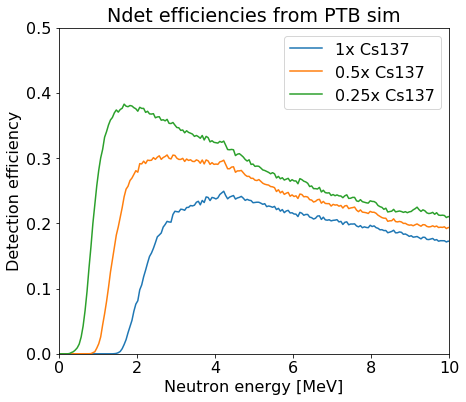

In [31]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (7,6)

plt.plot(df_eff['6M'],df_eff['1xCs bias'], label='1x Cs137')
plt.plot(df_eff['6M'],df_eff['0.5xCs'], label='0.5x Cs137')
plt.plot(df_eff['6M'],df_eff['0.25xCs'], label='0.25x Cs137')

plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Detection efficiency')

plt.legend()

plt.xlim(0.,10.)
plt.ylim(0.,0.5)

plt.title('Ndet efficiencies from PTB sim')

plt.savefig('Plots/PSDAnalysis/ndet_efficiencies_from_ptb.png',\
           dpi=200,bbox_inches='tight')




